In [30]:
# 📌 Import Required Libraries
import pandas as pd
import numpy as np
import joblib
import rioxarray as rxr
from tqdm import tqdm

# ✅ Load Trained Models & Preprocessors
rf_model = joblib.load("../models/rf_model.pkl")
xgb_model = joblib.load("../models/xgb_model.pkl")
scaler = joblib.load("../models/scaler.pkl")
feature_names = joblib.load("../models/feature_names.pkl")  # Expected feature names

print("✅ Models and Scaler Loaded Successfully")

# 📌 Load Submission Data
submission_data = pd.read_csv("../data/raw/Submission_template.csv")
print(f"✅ Loaded Submission Data. Shape: {submission_data.shape}")
print("📌 Available Columns:", submission_data.columns.tolist())

# 📌 Sentinel-2 GeoTIFF Path
tiff_path = "../data/raw/S2_sample.tiff"

# ✅ Extract Band Features from GeoTIFF
def extract_band_values(tiff_path, csv_data):
    """Extract Sentinel-2 band values from a GeoTIFF based on Lat/Lon coordinates."""
    data = rxr.open_rasterio(tiff_path)
    band_values = { "B01": [], "B06": [], "B08": [] }

    for lat, lon in tqdm(zip(csv_data["Latitude"], csv_data["Longitude"]), total=len(csv_data), desc="Extracting Sentinel-2 Data"):
        try:
            b01 = float(data.sel(x=lon, y=lat, band=1, method="nearest").values)
            b06 = float(data.sel(x=lon, y=lat, band=3, method="nearest").values)
            b08 = float(data.sel(x=lon, y=lat, band=4, method="nearest").values)

            band_values["B01"].append(b01)
            band_values["B06"].append(b06)
            band_values["B08"].append(b08)

        except Exception as e:
            print(f"⚠️ Error at ({lat}, {lon}): {e}")
            band_values["B01"].append(np.nan)
            band_values["B06"].append(np.nan)
            band_values["B08"].append(np.nan)

    return pd.DataFrame(band_values)

# 🔍 Extract Features
sentinel_features = extract_band_values(tiff_path, submission_data)

# ✅ Compute NDVI (Normalized Difference Vegetation Index)
sentinel_features["NDVI"] = (sentinel_features["B08"] - sentinel_features["B01"]) / (sentinel_features["B08"] + sentinel_features["B01"])
sentinel_features["NDVI"].replace([np.inf, -np.inf], np.nan, inplace=True)

# ✅ Merge Extracted Features into Submission Data
submission_data = pd.concat([submission_data, sentinel_features], axis=1)

# 📌 **Standardize Column Names**
submission_data.columns = submission_data.columns.str.lower().str.replace(" ", "_")

# ✅ **Ensure Matching Feature Names Before Scaling**
expected_features = [col.lower().replace(" ", "_") for col in feature_names]

# ✅ **Handle Missing Features**
for col in expected_features:
    if col not in submission_data.columns:
        print(f"⚠️ Missing Feature: {col}. Filling with default value 0...")
        submission_data[col] = 0  # Default fill for missing columns

# ✅ **Align Columns & Ensure Correct Order**
submission_features = submission_data[expected_features]  

# 📌 **Apply Standard Scaling**
try:
    scaled_features = scaler.transform(submission_features)
except ValueError as e:
    print("🚨 Feature Mismatch Error:", e)
    print("⚠️ Skipping Scaling to Debug Feature Issue...")
    scaled_features = submission_features.to_numpy()  # Bypass scaling temporarily

# ✅ Convert to DataFrame & Align with Feature Names
submission_final = pd.DataFrame(scaled_features, columns=feature_names)

# 📌 Make Predictions using Trained Models
rf_predictions = rf_model.predict(submission_final)
xgb_predictions = xgb_model.predict(submission_final)

# 📌 Aggregate Predictions (Ensemble)
final_predictions = (rf_predictions + xgb_predictions) / 2

# 📌 Create Submission File
submission_df = pd.DataFrame({
    "Longitude": submission_data["longitude"],
    "Latitude": submission_data["latitude"],
    "UHI Index": final_predictions.round(5)  # ✅ Round UHI Index to 5 decimal places
})

# ✅ Save Submission File
submission_path = "../data/submission.csv"
submission_df.to_csv(submission_path, index=False)
print(f"✅ Submission File Created: {submission_path}")

✅ Models and Scaler Loaded Successfully
✅ Loaded Submission Data. Shape: (1040, 3)
📌 Available Columns: ['Longitude', 'Latitude', 'UHI Index']


Extracting Sentinel-2 Data: 100%|██████████| 1040/1040 [00:01<00:00, 955.60it/s]
/var/folders/y0/slhcnc5d5ylcv5sf0glxtrvr0000gn/T/ipykernel_81741/3133153453.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sentinel_features["NDVI"].replace([np.inf, -np.inf], np.nan, inplace=True)


⚠️ Missing Feature: land_surface_temp. Filling with default value 0...
⚠️ Missing Feature: band1. Filling with default value 0...
⚠️ Missing Feature: band2. Filling with default value 0...
⚠️ Missing Feature: band3. Filling with default value 0...
⚠️ Missing Feature: band4. Filling with default value 0...
⚠️ Missing Feature: air_temp_at_surface_. Filling with default value 0...
⚠️ Missing Feature: relative_humidity_. Filling with default value 0...
⚠️ Missing Feature: avg_wind_speed_. Filling with default value 0...
⚠️ Missing Feature: wind_direction_. Filling with default value 0...
⚠️ Missing Feature: solar_flux_. Filling with default value 0...
⚠️ Missing Feature: hour. Filling with default value 0...
⚠️ Missing Feature: weekday. Filling with default value 0...
⚠️ Missing Feature: month. Filling with default value 0...
⚠️ Missing Feature: building_distance_m. Filling with default value 0...
⚠️ Missing Feature: hour_category_afternoon. Filling with default value 0...
⚠️ Missing Featu

✅ Loaded Submission Data. Shape: (1040, 3)
📌 Available Columns: ['Longitude', 'Latitude', 'UHI Index']
📊 UHI Index Summary:
count    1040.000000
mean        0.999339
std         0.012768
min         0.975440
25%         0.987187
50%         1.004470
75%         1.008977
max         1.027790
Name: UHI Index, dtype: float64


/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


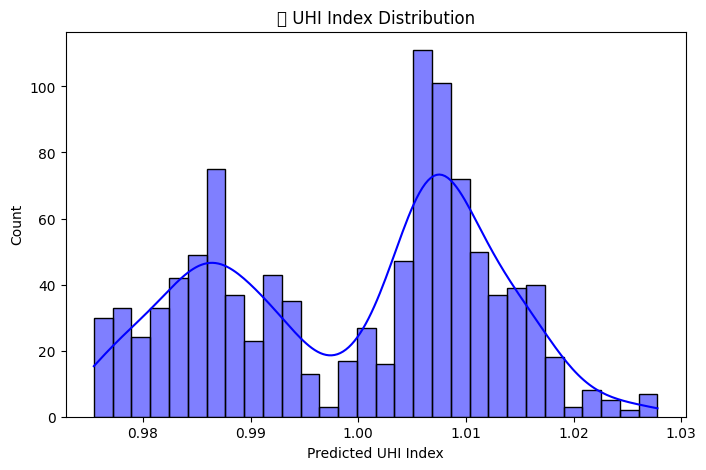

/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


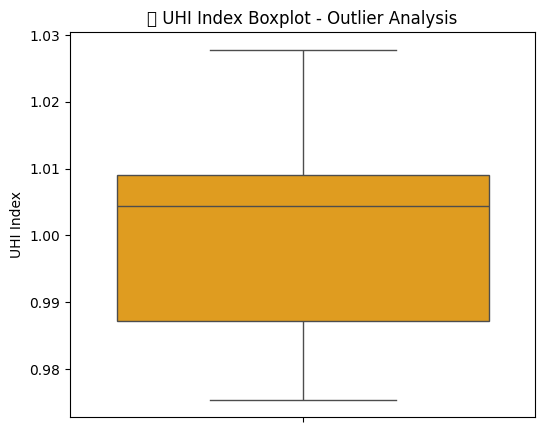

/var/folders/y0/slhcnc5d5ylcv5sf0glxtrvr0000gn/T/ipykernel_81741/1131762987.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(submission_df["UHI Index"], shade=True, color="green")
/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


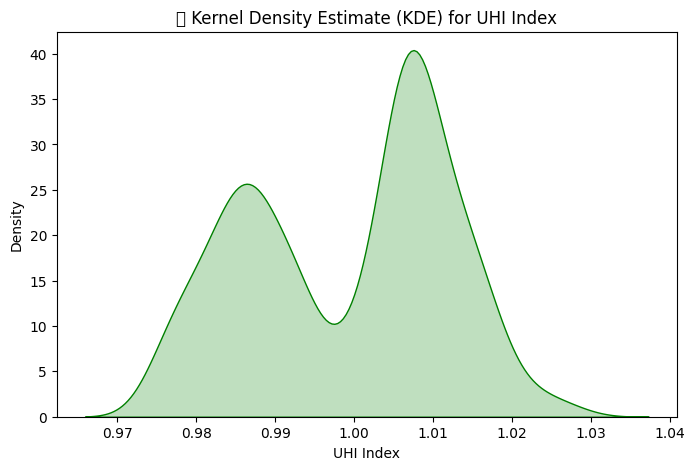

/var/folders/y0/slhcnc5d5ylcv5sf0glxtrvr0000gn/T/ipykernel_81741/1131762987.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
/Users/viditgupta/UHI-Predictor/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


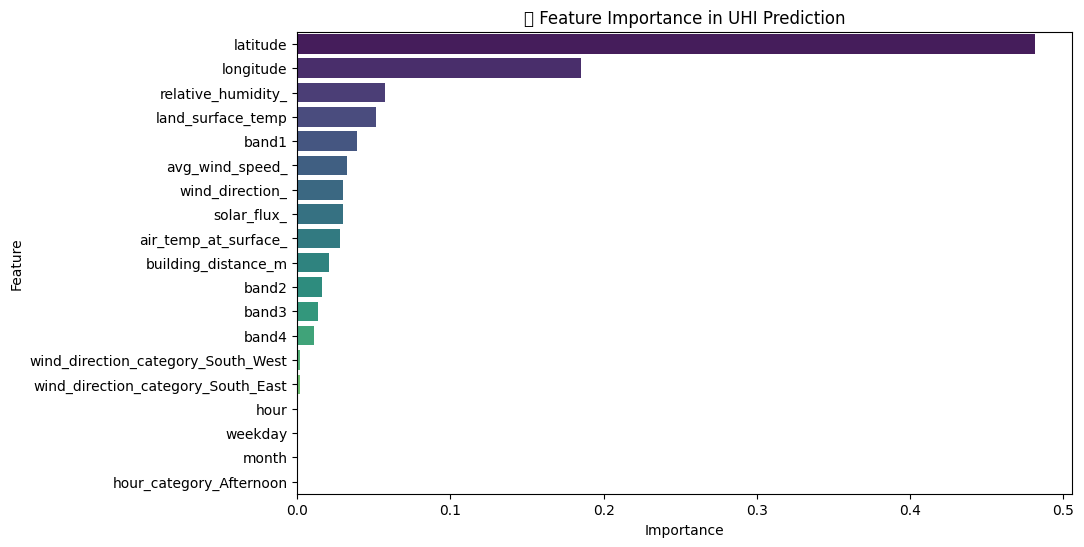

⚠️ Potential Outliers Detected: 0 values outside expected range
✅ Validated submission file saved as 'validated_submission.csv'


In [34]:
# 📌 Import Required Libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load Submission Data
submission_df = pd.read_csv("../data/submission.csv")

# ✅ Check Data
print(f"✅ Loaded Submission Data. Shape: {submission_df.shape}")
print(f"📌 Available Columns: {submission_df.columns.tolist()}")
print(f"📊 UHI Index Summary:\n{submission_df['UHI Index'].describe()}")

# ✅ **Step 1: Distribution Analysis**
plt.figure(figsize=(8, 5))
sns.histplot(submission_df["UHI Index"], bins=30, kde=True, color="blue")
plt.xlabel("Predicted UHI Index")
plt.title("📊 UHI Index Distribution")
plt.show()

# ✅ **Step 2: Boxplot to Check Outliers**
plt.figure(figsize=(6, 5))
sns.boxplot(y=submission_df["UHI Index"], color="orange")
plt.title("📦 UHI Index Boxplot - Outlier Analysis")
plt.show()

# ✅ **Step 3: KDE Plot for UHI Density**
plt.figure(figsize=(8, 5))
sns.kdeplot(submission_df["UHI Index"], shade=True, color="green")
plt.xlabel("UHI Index")
plt.title("📈 Kernel Density Estimate (KDE) for UHI Index")
plt.show()

# ✅ **Step 4: Feature Importance Analysis**
# Load Model (Use your trained model)
rf_model = joblib.load("../models/rf_model.pkl")  # Adjust path as needed
feature_names = joblib.load("../models/feature_names.pkl")

# Extract Feature Importance (If Using Random Forest or XGBoost)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# ✅ **Step 5: Plot Feature Importance**
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("🔍 Feature Importance in UHI Prediction")
plt.show()

# ✅ **Step 6: Compare With Expected Range**
uhi_min, uhi_max = 0.9, 1.1  # Adjust based on expected UHI range
outliers = submission_df[(submission_df["UHI Index"] < uhi_min) | (submission_df["UHI Index"] > uhi_max)]
print(f"⚠️ Potential Outliers Detected: {outliers.shape[0]} values outside expected range")

# ✅ **Step 7: Save Processed Data**
submission_df.to_csv("validated_submission.csv", index=False)
print("✅ Validated submission file saved as 'validated_submission.csv'")